In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
#import tensorflow as tf
#assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('font', family = 'simhei')
mpl.rc('font', size = 16)
mpl.rc('axes', unicode_minus = False)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 感知器

In [2]:
# 使用单一感知器分类鸢尾植物类别
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # 特征：根茎长度、宽度
y = (iris.target == 0).astype(np.int64)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1], dtype=int64)

展示一下感知器分类的决策平面

Saving figure 单一感知器分类鸢尾植物


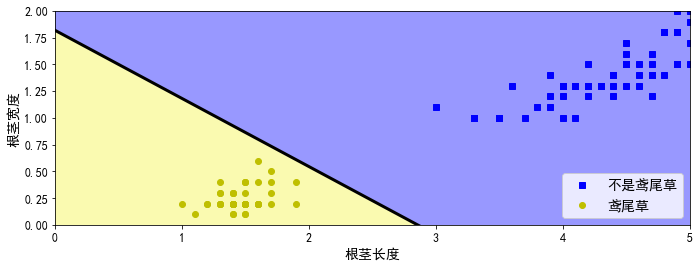

In [3]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="不是鸢尾草")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="鸢尾草")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("根茎长度", fontsize=14)
plt.ylabel("根茎宽度", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("单一感知器分类鸢尾植物")
plt.show()

简单感知器的学习算法非常类似于随机梯度下降，其实当SGDClassifier对象的损失函数是'perceptron'的时候，等同于单一感知器

In [4]:
from sklearn.linear_model import SGDClassifier

per_clf = SGDClassifier(loss = 'perceptron', max_iter=1000, tol=1e-3, random_state=42, penalty = None, 
                        learning_rate = 'constant', eta0 = 1) # 设置学习率保持不变一直为1
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1], dtype=int64)

# 激活函数

In [5]:
# 这是几种流行的激活函数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure 几种流行的激活函数


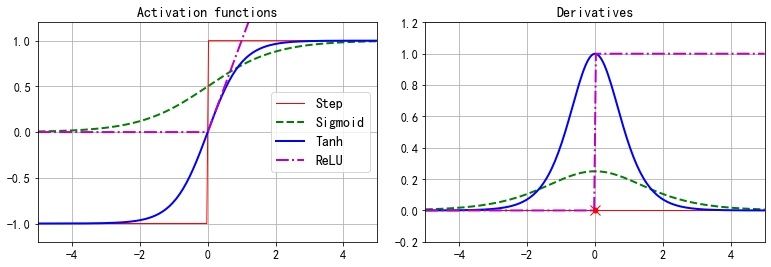

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("几种流行的激活函数")
plt.show()

# keras搭建一个图片分类器

In [7]:
import tensorflow as tf
from tensorflow import keras

In [8]:
import numpy as np

In [9]:
# 获取图片像素数据
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [10]:
X_train_full.shape

(60000, 28, 28)

In [11]:
# 像素值的范围时0-255
X_train_full.dtype

dtype('uint8')

In [12]:
# 因为使用梯度下降来最小化误差，所以需最好先对输入数据进行归一化缩放
# 再分出一点数据作为验证集
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

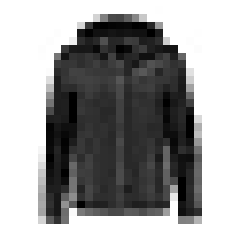

In [13]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [14]:
# 图片共计有10个类别，使用单一数据进行指代
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [15]:
# 这是各个类别的实际含义，如第一个图片是Coat
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names[y_train[0]]

'Coat'

Saving figure fashion_mnist_plot


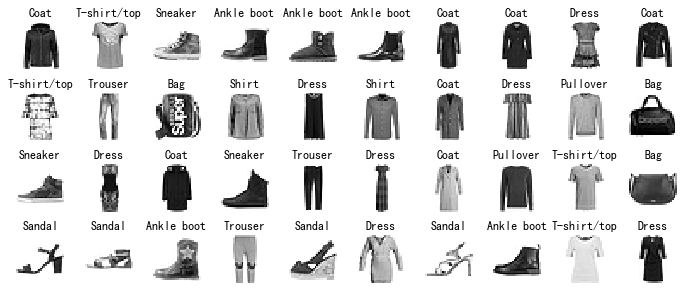

In [16]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

## 1. 初始化

创建一个最简单的顺序神经网络  
这是两种初始化创建的方法

In [17]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
from functools import partial

model = keras.models.Sequential()
# input_shape参数是keras.layers的build()方法的参数
# 当创建一个一个layer时，自动调用build()方法，所以可以使用input_shape参数
model.add(keras.layers.Flatten(input_shape = [28, 28], name = 'input0'))
model.add(keras.layers.Dense(300, activation = partial(keras.activations.relu, alpha = 0.2), name = 'hidden0'))
model.add(keras.layers.Dense(100, activation = partial(keras.activations.relu, alpha = 0.1), name = 'hidden1'))
model.add(keras.layers.Dense(10, activation = keras.activations.softmax, name = 'output0'))

In [19]:
# 重新设置随机状态
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
# 查看模型的layers列表
model.layers

In [21]:
# 还可以看看更详细的列表
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input0 (Flatten)            (None, 784)               0         
                                                                 
 hidden0 (Dense)             (None, 300)               235500    
                                                                 
 hidden1 (Dense)             (None, 100)               30100     
                                                                 
 output0 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


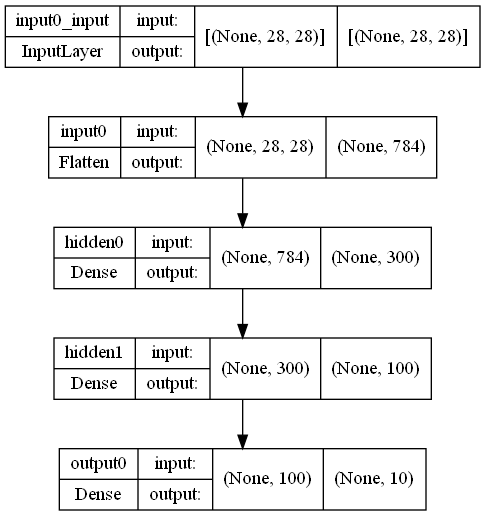

In [22]:
# 也可以看到整个网络的流程图
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [23]:
# 可以通过新的变量单独指定某一个layer
hidden0 = model.layers[1]
hidden0.name

'hidden0'

In [24]:
model.get_layer(hidden0.name) is hidden0

True

In [25]:
# 可以分别获取某一layer的各神经元和偏置项的连接权重，注意此时的权重是随机生成的
# 因为还没进行训练呢
weights, biases = hidden0.get_weights()
# 这是各神经元的连接权重
print(weights.shape)
weights

(784, 300)


array([[ 0.00864818,  0.00866   ,  0.06277764, ..., -0.06367455,
         0.06115508,  0.05742359],
       [ 0.0360974 ,  0.0555031 , -0.00253352, ..., -0.02812578,
         0.07046451, -0.0641923 ],
       [-0.03559544,  0.04436044, -0.0433822 , ..., -0.06232546,
        -0.05124569,  0.04945254],
       ...,
       [ 0.00598887,  0.01706156, -0.03820892, ...,  0.00654906,
        -0.06141194,  0.06620304],
       [-0.02407452, -0.06759316, -0.03484555, ...,  0.02098012,
         0.05039647,  0.02890825],
       [-0.04691515,  0.07101114, -0.01180091, ..., -0.0353616 ,
        -0.02863952, -0.03047926]], dtype=float32)

In [26]:
# 这是偏置项的连接权重，初始化状态可以是0
print(biases.shape)
biases

(300,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## 2. 编译模型

In [27]:
# 在这个环节，可以指定loss函数、优化器、和metrics
model.compile(loss = keras.losses.sparse_categorical_crossentropy,
              optimizer = keras.optimizers.SGD(),
              metrics = [[keras.metrics.sparse_categorical_accuracy]])

## 3. 训练模型

In [28]:
history = model.fit(X_train, y_train, epochs=30, # 进行30个轮次的训练
                    validation_data = (X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7081 - sparse_categorical_accuracy: 0.7645 - val_loss: 0.5174 - val_sparse_categorical_accuracy: 0.8236
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4878 - sparse_categorical_accuracy: 0.8283 - val_loss: 0.4414 - val_sparse_categorical_accuracy: 0.8464
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4454 - sparse_categorical_accuracy: 0.8422 - val_loss: 0.5508 - val_sparse_categorical_accuracy: 0.7924
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4192 - sparse_categorical_accuracy: 0.8540 - val_loss: 0.4003 - val_sparse_categorical_accuracy: 0.8646
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4017 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.3838 - val_sparse_categorical_accuracy: 0.8670
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3835 - spars

In [29]:
# 模型训练完成后返回的是History对象，其属性就是模型训练时的各种细节
print('模型参数:', history.params)
print('训练轮次编号:', history.epoch)
print('训练集、验证集的指标:', history.history.keys())

模型参数: {'verbose': 1, 'epochs': 30, 'steps': 1719}
训练轮次编号: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
训练集、验证集的指标: dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


Saving figure keras_learning_curves_plot


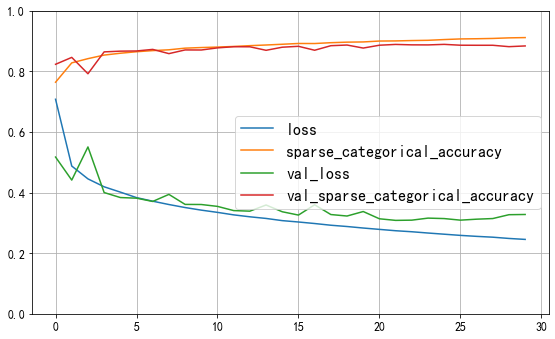

In [30]:
# 使用history.history中的每个轮次的指标，可以画出学习曲线
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

## 3. 使用测试集对模型进行评估

In [31]:
# 分别返回loss和metric的值
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3565 - sparse_categorical_accuracy: 0.8747


[0.35651543736457825, 0.8747000098228455]

## 4. 使用模型进行预测

In [32]:
# 随便从训练集中取三个实例进行测试
# 可以看到每个类别的概率
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.04, 0.  , 0.94],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [33]:
# 如果只想要概率最高的类别，可以这么写
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [34]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [35]:
# 这三个分类的结果是正确的，这是实际的分类
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

分类结果可视化

Saving figure fashion_mnist_images_plot


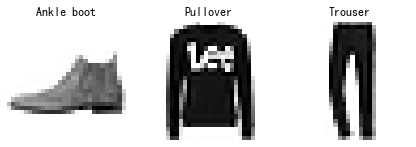

In [36]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# 使用顺序API构建一个回归MLP

还是使用加州住房数据进行测试，但是这次输入的住房数据只包含数字型变量

In [37]:
# 数据前处理
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [38]:
# 初始化模型，这次输出层只有一个并且没有激活函数
# 由于数据噪音较多，所以只使用一层隐含层以防止过拟合
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
# 模型编译，注意这次的loss函数变为mean_squared_error
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
# 训练模型
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
# 评估模型
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
# 使用模型预测
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6419 - val_loss: 0.8556
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4875 - val_loss: 0.4656

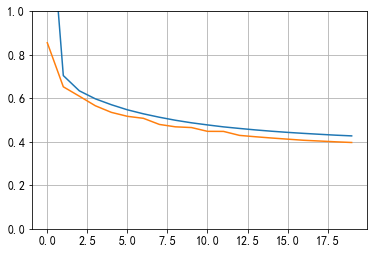

In [39]:
# 画一下子学习曲线
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# 函数式API创建神经网络

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

## 单一输入宽深神经网络

In [41]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
# 这既是为什么叫函数式了，直接使用函数调用的方式来连接各个layer
# 这行的意思是input_输入层输出到hidden1隐含层中
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
# 将一部分的输入层的输出直接与hidden2合并后输出
concat = keras.layers.concatenate([input_, hidden2])
# 合并输出后，由输出层输出，只有一个感知器
output = keras.layers.Dense(1)(concat)
# 然后再创建模型，只需指定输入和输出层就行，因为输入与输出层都已经与其它层连接到一起了
model = keras.models.Model(inputs=[input_], outputs=[output])

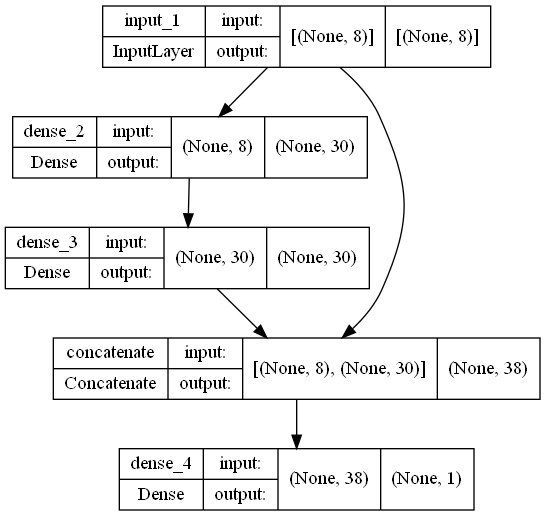

In [42]:
keras.utils.plot_model(model, "简单的宽深神经网络.png", show_shapes=True)

In [44]:
model.compile(loss = "mean_squared_error", 
              optimizer = keras.optimizers.SGD(learning_rate=1e-3)
             )

history = model.fit(X_train, y_train, epochs=20,
                    validation_data = (X_valid, y_valid)
                   )
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.2610 - val_loss: 3.3896
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6580 - val_loss: 0.9363
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5879 - val_loss: 0.5650
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5582 - val_loss: 0.5713
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5348 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4876 - val_loss: 0.4634
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4760 - val_loss: 0.4422
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4659 - val_loss: 0.4313

## 多输入宽深神经网络

In [47]:
# 宽路径输入，输入5个变量
input_A = keras.layers.Input(shape=[5], name="wide_input")
# 深路径输入，输入6个变量
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
# 这里注意在创建模型的时候要指定有两个输入
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

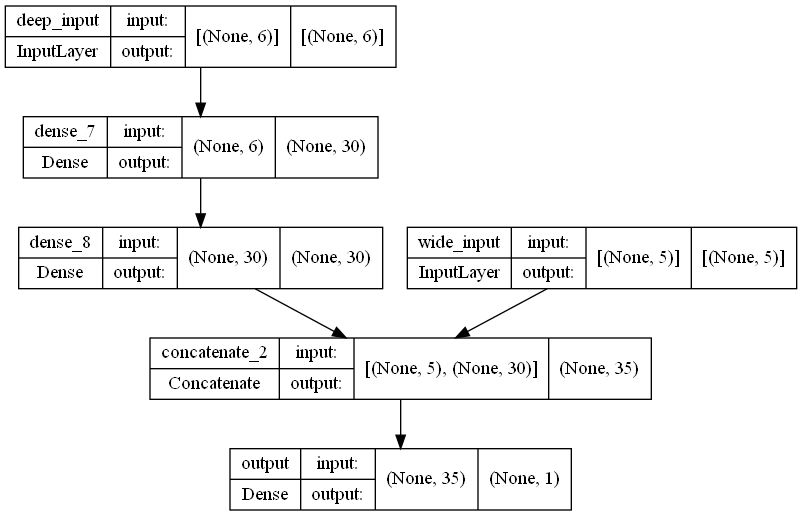

In [48]:
keras.utils.plot_model(model, "多输入的宽深神经网络.png", show_shapes=True)

In [49]:
model.compile(loss = "mse", 
              optimizer = keras.optimizers.SGD(learning_rate=1e-3)
             )

# 这里要注意要将X_train分成两部分输入
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.1094 - val_loss: 1.0291
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7849 - val_loss: 0.6906
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6517 - val_loss: 0.6051
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5964 - val_loss: 0.5448
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5594 - val_loss: 0.5131
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5310 - val_loss: 0.4875
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5082 - val_loss: 0.4678
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4895 - val_loss: 0.4510
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4746 - val_loss: 0.4377
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4639 - val_loss: 0.4271

## 多输出宽深神经网路

In [50]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
# 注意指定这两个输出
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

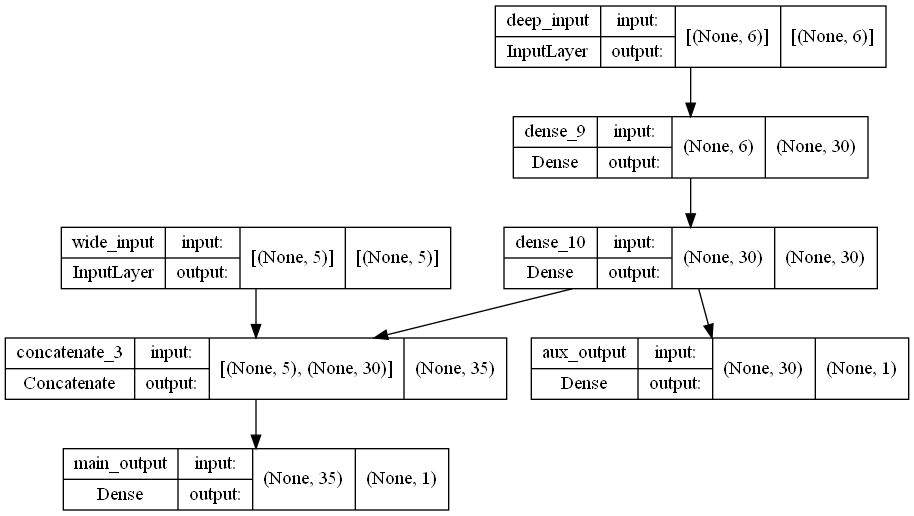

In [51]:
keras.utils.plot_model(model, "多输出的宽深神经网络.png", show_shapes=True)

In [65]:
model.compile(loss=["mape", 'mse'], # 在编译的时候注意，在有多输出的时候可以指定多个损失函数，如果只有一个损失函数，则所有输出都会使用同一个loss
              loss_weights={'main_output':0.9, 'aux_output':0.1}, # 可以指定各个输出在计算损失函数的比重
              optimizer=keras.optimizers.SGD(learning_rate=1e-3)
             )

history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=10,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))
mse_test = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred = model.predict([X_new_A, X_new_B])

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 7.2750 - main_output_loss: 17.7419 - aux_output_loss: 0.3564 - val_loss: 8.7971 - val_main_output_loss: 20.8631 - val_aux_output_loss: 0.9038
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 7.2670 - main_output_loss: 17.7172 - aux_output_loss: 0.3601 - val_loss: 7.7195 - val_main_output_loss: 18.8673 - val_aux_output_loss: 0.3451
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 7.2579 - main_output_loss: 17.7018 - aux_output_loss: 0.3544 - val_loss: 7.6982 - val_main_output_loss: 18.7601 - val_aux_output_loss: 0.3884
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 7.2663 - main_output_loss: 17.7209 - aux_output_loss: 0.3559 - val_loss: 7.6614 - val_main_output_loss: 18.7202 - val_aux_output_loss: 0.3467
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 7.2347 - main_output_loss: 17.6427 - aux_output_loss: 0.3553 -

In [70]:
# 在评估模型的时候，分别会输出总loss，和分别各个输出的loss
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 2ms/step - loss: 7.3404 - main_output_loss: 17.9042 - aux_output_loss: 0.3574


Saving figure keras_learning_curves_plot


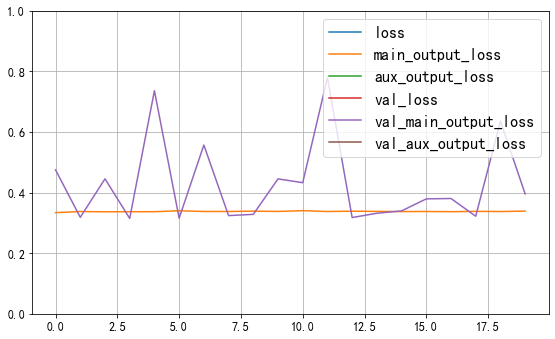

In [62]:
# 使用history.history中的每个轮次的指标，可以画出学习曲线
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()